In [1]:
import pandas as pd
from collections import Counter
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json
from matplotlib import rcParams
import geopandas as gpd

In [2]:
df = pd.read_csv('BasicCompanyDataAsOneFile-2021-12-01.csv')

/Users/oliwiawcislo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (41,42,43,44,45,46,47,48,49,50,51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
df2 = pd.read_csv('postcodes.csv')

/Users/oliwiawcislo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (7,17,18,21,22,24,25,29,32,39,47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
CheckEng = df[(df["RegAddress.Country"] != "ENGLAND")].index
df.drop(CheckEng, inplace=True)

In [5]:
#using only company details and SIC codes
df_subset = df.iloc[:, np.r_[0:15, 26:30]]

In [6]:
df_subset['IncorporationDate'] = pd.to_datetime(df_subset['IncorporationDate'], errors = 'coerce')
df_subset = df_subset[df_subset.IncorporationDate >= "01/01/2019"]

/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/2383652702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['IncorporationDate'] = pd.to_datetime(df_subset['IncorporationDate'], errors = 'coerce')


In [7]:
df_subset = df_subset.dropna(subset=['SICCode.SicText_1']) #dropNA

In [8]:
df_subset = df_subset[df_subset["SICCode.SicText_1"] != "99999 - Dormant Company"] #drop dormant

In [9]:
df_subset = df_subset[df_subset["SICCode.SicText_1"] != "None Supplied"]

In [10]:
df_subset = df_subset.loc[df_subset["SICCode.SicText_1"].notnull()]

In [11]:
df_subset.loc[:, "SICCode_1_twod"] = df_subset["SICCode.SicText_1"].str[0:2]

In [12]:
df_subset["num_of_sic"] = 4-(df_subset[["SICCode.SicText_1", "SICCode.SicText_2",
                                        "SICCode.SicText_3", "SICCode.SicText_4"]].isnull().sum(axis=1))

In [13]:
Sic1 = df_subset['SICCode_1_twod'].to_numpy()
Sic1 = Sic1.astype(str).astype(int)
df_subset['Sic1Names'] = Sic1

In [14]:
def SICtoIndustry(SICCode):
    if SICCode in [i for i in range(1, 4)]:
        SICCode = "Agriculture, Forestry and Fishing"
    elif SICCode in [i for i in range(5, 10)]:
        SICCode = "Mining and Quarrying"
    elif SICCode in [i for i in range(10, 34)]:
        SICCode = "Manufacturing"
    elif SICCode == 35:
        SICCode = "Electricity, gas, steam and air conditioning supply"
    elif SICCode in [i for i in range(36, 40)]:
        SICCode = "Water supply, sewerage, waste management and remediation activities"
    elif SICCode in [i for i in range(41, 44)]:
        SICCode = "Construction"
    elif SICCode in [i for i in range(45, 48)]:
        SICCode = "Wholesale and retail trade; repair of motor vehicles and motorcycles"
    elif SICCode in [i for i in range(49, 54)]:
        SICCode = "Transportation and storage"
    elif SICCode in [i for i in range(55, 57)]:
        SICCode = "Accommodation and food service activities"
    elif SICCode in [i for i in range(58, 64)]:
        SICCode = "Information and communication"
    elif SICCode in [i for i in range(64, 67)]:
        SICCode = "Financial and insurance activities"
    elif SICCode == 68:
        SICCode = "Real estate activities"
    elif SICCode in [i for i in range(69, 76)]:
        SICCode = "Professional, scientific and technical activities"
    elif SICCode in [i for i in range(77, 83)]:
        SICCode = "Administrative and support service activities"
    elif SICCode == 84:
        SICCode = "Public administration and defence; compulsory social security"
    elif SICCode == 85:
        SICCode = "Education"
    elif SICCode in [i for i in range(86, 89)]:
        SICCode = "Human health and social work activities"
    elif SICCode in [i for i in range(90, 94)]:
        SICCode = "Arts, entertainment and recreation"
    elif SICCode in [i for i in range(94, 97)]:
        SICCode = "Other service activities"
    elif SICCode in [i for i in range(97, 98)]:
        SICCode = "Activities of households as employers; undifferentiated goods- and services-producing activities of households for own use"
    elif SICCode == 99:
        SICCode = "Activities of extraterritorial organisations and bodies"
    else:
        SICCode = np.NAN
    return SICCode

In [15]:
df_subset["SIC_1_Industry"] = df_subset["Sic1Names"].apply(SICtoIndustry)

In [16]:
x = df_subset.copy()
y = df2 [['Postcode', 'County', 'Country', 'Latitude', 'Longitude'] ]

In [17]:
df_withloc = pd.merge(x,y, how = 'left', left_on = 'RegAddress.PostCode', right_on = 'Postcode')

In [18]:
cols= [' CompanyNumber','CompanyName','RegAddress.CareOf','RegAddress.POBox','RegAddress.AddressLine1',' RegAddress.AddressLine2','RegAddress.PostTown','RegAddress.County','RegAddress.Country','RegAddress.PostCode','CompanyCategory','CompanyStatus','CountryOfOrigin','DissolutionDate','SICCode.SicText_1','SICCode.SicText_2','SICCode.SicText_3','SICCode.SicText_4','SICCode_1_twod','num_of_sic','Sic1Names']
df_subset.drop(cols, axis=1, inplace=True)

In [19]:
df_subset.T

,3,11,13,14,19,33,40,49,61,65,...,5016183,5016184,5016185,5016186,5016188,5016189,5016191,5016192,5016198,5016202
IncorporationDate,2021-05-17 00:00:00,2021-12-08 00:00:00,2021-02-23 00:00:00,2021-01-04 00:00:00,2020-04-08 00:00:00,2020-12-02 00:00:00,2019-07-29 00:00:00,2020-12-30 00:00:00,2019-01-10 00:00:00,2020-05-11 00:00:00,...,2020-10-16 00:00:00,2021-05-14 00:00:00,2020-08-31 00:00:00,2020-07-24 00:00:00,2021-10-11 00:00:00,2021-03-29 00:00:00,2019-08-16 00:00:00,2019-12-08 00:00:00,2021-03-22 00:00:00,2020-05-30 00:00:00
SIC_1_Industry,Information and communication,Information and communication,Wholesale and retail trade; repair of motor ve...,Real estate activities,Transportation and storage,Education,Human health and social work activities,"Professional, scientific and technical activities",Manufacturing,Construction,...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Other service activities,Transportation and storage,Information and communication,Construction,Information and communication,Administrative and support service activities,Accommodation and food service activities,Other service activities


In [20]:
df_subset.columns

Index(['IncorporationDate', 'SIC_1_Industry'], dtype='object')

In [21]:
wholesale = df_subset[df_subset["SIC_1_Industry"]=='Wholesale and retail trade; repair of motor vehicles and motorcycles']
real_estate = df_subset[df_subset["SIC_1_Industry"]=='Real estate activities']
accommodation = df_subset[df_subset["SIC_1_Industry"]=='Accommodation and food service activities']

In [22]:
accommodation['year'] = pd.DatetimeIndex(accommodation['IncorporationDate']).year
accommodation['month'] = pd.DatetimeIndex(accommodation['IncorporationDate']).month
accommodation['month_year'] = accommodation['IncorporationDate'].dt.to_period('M')

/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/45900792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accommodation['year'] = pd.DatetimeIndex(accommodation['IncorporationDate']).year
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/45900792.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accommodation['month'] = pd.DatetimeIndex(accommodation['IncorporationDate']).month
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/45900792.py:3: SettingWithCop

In [23]:
real_estate['year'] = pd.DatetimeIndex(real_estate['IncorporationDate']).year
real_estate['month'] = pd.DatetimeIndex(real_estate['IncorporationDate']).month
real_estate['month_year'] = real_estate['IncorporationDate'].dt.to_period('M')

/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/1523415780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_estate['year'] = pd.DatetimeIndex(real_estate['IncorporationDate']).year
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/1523415780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_estate['month'] = pd.DatetimeIndex(real_estate['IncorporationDate']).month
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/1523415780.py:3: SettingWithCopyW

In [24]:
wholesale['year'] = pd.DatetimeIndex(wholesale['IncorporationDate']).year
wholesale['month'] = pd.DatetimeIndex(wholesale['IncorporationDate']).month
wholesale['month_year'] = wholesale['IncorporationDate'].dt.to_period('M')

/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/3981348625.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholesale['year'] = pd.DatetimeIndex(wholesale['IncorporationDate']).year
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/3981348625.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wholesale['month'] = pd.DatetimeIndex(wholesale['IncorporationDate']).month
/var/folders/6p/zkn5q88n29zbfkpslgh2pw0w0000gn/T/ipykernel_21842/3981348625.py:3: SettingWithCopyWarning: 

In [25]:
lineplot_df = pd.concat([wholesale, real_estate, accommodation])

In [26]:
df_month_counter = lineplot_df.groupby(['SIC_1_Industry', 
                    'month_year']).count()
df_month_counter.reset_index(inplace = True)

In [27]:
wholesale_month = wholesale.groupby(['SIC_1_Industry', 
                    'month_year']).count()
wholesale_month.reset_index(inplace = True)

In [28]:
real_estate_month = real_estate.groupby(['SIC_1_Industry', 
                    'month_year']).count()
real_estate_month.reset_index(inplace = True)

In [29]:
accommodation_month = accommodation.groupby(['SIC_1_Industry', 
                    'month_year']).count()
accommodation_month.reset_index(inplace = True)

In [30]:
df_month_counter.T

,0,1,2,3,4,5,6,7,8,9,...,98,99,100,101,102,103,104,105,106,107
SIC_1_Industry,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...
month_year,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10,...,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,2021-09,2021-10,2021-11,2021-12
IncorporationDate,1273,1111,1400,1384,1541,1286,1303,1354,1508,1595,...,7176,7228,6375,6050,5477,6342,6427,6097,6344,2641
year,1273,1111,1400,1384,1541,1286,1303,1354,1508,1595,...,7176,7228,6375,6050,5477,6342,6427,6097,6344,2641
month,1273,1111,1400,1384,1541,1286,1303,1354,1508,1595,...,7176,7228,6375,6050,5477,6342,6427,6097,6344,2641


In [31]:
rcParams['figure.figsize'] = 11.7,8.27

In [32]:
df_month_counter.sort_values(by=['month_year'])

,SIC_1_Industry,month_year,IncorporationDate,year,month
0,Accommodation and food service activities,2019-01,1273,1273,1273
72,Wholesale and retail trade; repair of motor ve...,2019-01,2190,2190,2190
36,Real estate activities,2019-01,1564,1564,1564
1,Accommodation and food service activities,2019-02,1111,1111,1111
73,Wholesale and retail trade; repair of motor ve...,2019-02,2053,2053,2053
...,...,...,...,...,...
34,Accommodation and food service activities,2021-11,2375,2375,2375
70,Real estate activities,2021-11,2855,2855,2855
71,Real estate activities,2021-12,1272,1272,1272
35,Accommodation and food service activities,2021-12,927,927,927


Text(0, 0.5, 'Number of incorporations')

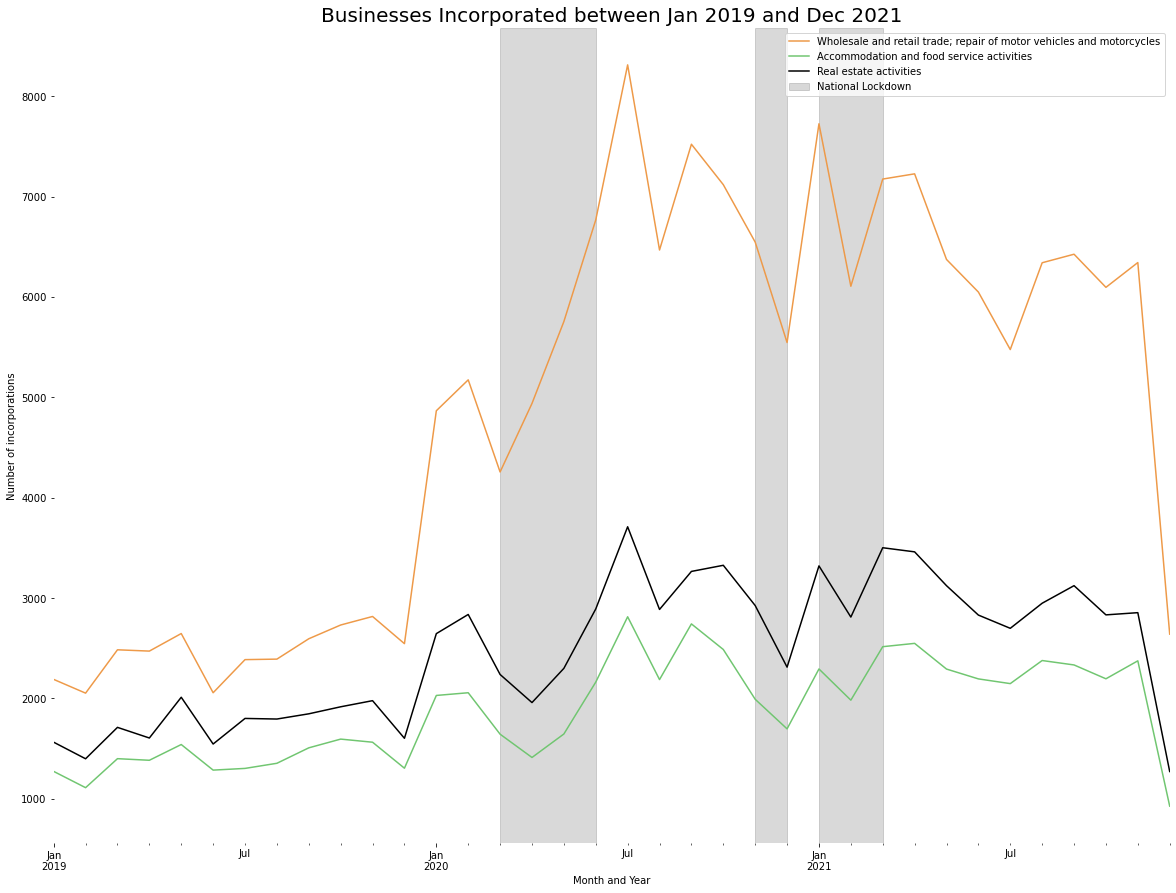

In [33]:
plt.rcParams["figure.figsize"] = (20,15)
ax = plt.gca()
ax.set_frame_on(False)
wholesale_month.plot(kind='line',x='month_year',y='year',ax=ax, label='Wholesale and retail trade; repair of motor vehicles and motorcycles', color = '#EE9A49')
accommodation_month.plot(kind='line',x='month_year',y='year',ax=ax,label='Accommodation and food service activities', color = '#71C671')
real_estate_month.plot(kind='line',x='month_year',y='year',ax=ax, label='Real estate activities', color = 'black')

ax.axvspan(pd.to_datetime('2020-03-23'), pd.to_datetime('2020-06-15'), color = 'black', alpha=0.15, label="National Lockdown")
ax.axvspan(pd.to_datetime('2020-11-05'), pd.to_datetime('2020-12-02'), color = 'black', alpha=0.15)
ax.axvspan(pd.to_datetime('2021-01-06'), pd.to_datetime('2021-03-29'), color = 'black', alpha=0.15)

plt.legend(loc="upper right")

ax.set_title('Businesses Incorporated between Jan 2019 and Dec 2021', fontsize=20)
plt.xlabel("Month and Year")
plt.ylabel("Number of incorporations")

In [34]:
df_month_counter2 = lineplot_df.groupby(['SIC_1_Industry', 
                    'year']).count()
df_month_counter2.reset_index(inplace = True)

In [35]:
df_month_counter2.T

,0,1,2,3,4,5,6,7,8
SIC_1_Industry,Accommodation and food service activities,Accommodation and food service activities,Accommodation and food service activities,Real estate activities,Real estate activities,Real estate activities,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...
year,2019,2020,2021,2019,2020,2021,2019,2020,2021
IncorporationDate,16624,24874,26188,20780,33302,34782,29373,73285,73992
month,16624,24874,26188,20780,33302,34782,29373,73285,73992
month_year,16624,24874,26188,20780,33302,34782,29373,73285,73992


In [36]:
df_month_counter2.set_index(['SIC_1_Industry', 'year'],
                      drop=True).unstack('year')


IncorporationDate         \
year                                                            2019   2020   
SIC_1_Industry                                                                
Accommodation and food service activities                      16624  24874   
Real estate activities                                         20780  33302   
Wholesale and retail trade; repair of motor veh...             29373  73285   

                                                           month         \
year                                                 2021   2019   2020   
SIC_1_Industry                                                            
Accommodation and food service activities           26188  16624  24874   
Real estate activities                              34782  20780  33302   
Wholesale and retail trade; repair of motor veh...  73992  29373  73285   

                                                          month_year         \
year                                                 2021       2019   2020   
SIC_1_Industry                                                                
Accommodation and food service activities           26188      16624  24874   
Real estate activities                              34782      20780  33302   
Wholesale and retail trade; repair of motor veh...  73992      29373  73285   

                                                           
year                                                 2021  
SIC_1_Industry                                             
Accommodation and food service activities           26188  
Real estate activities                              34782  
Wholesale and retail trade; repair of motor veh...  73992

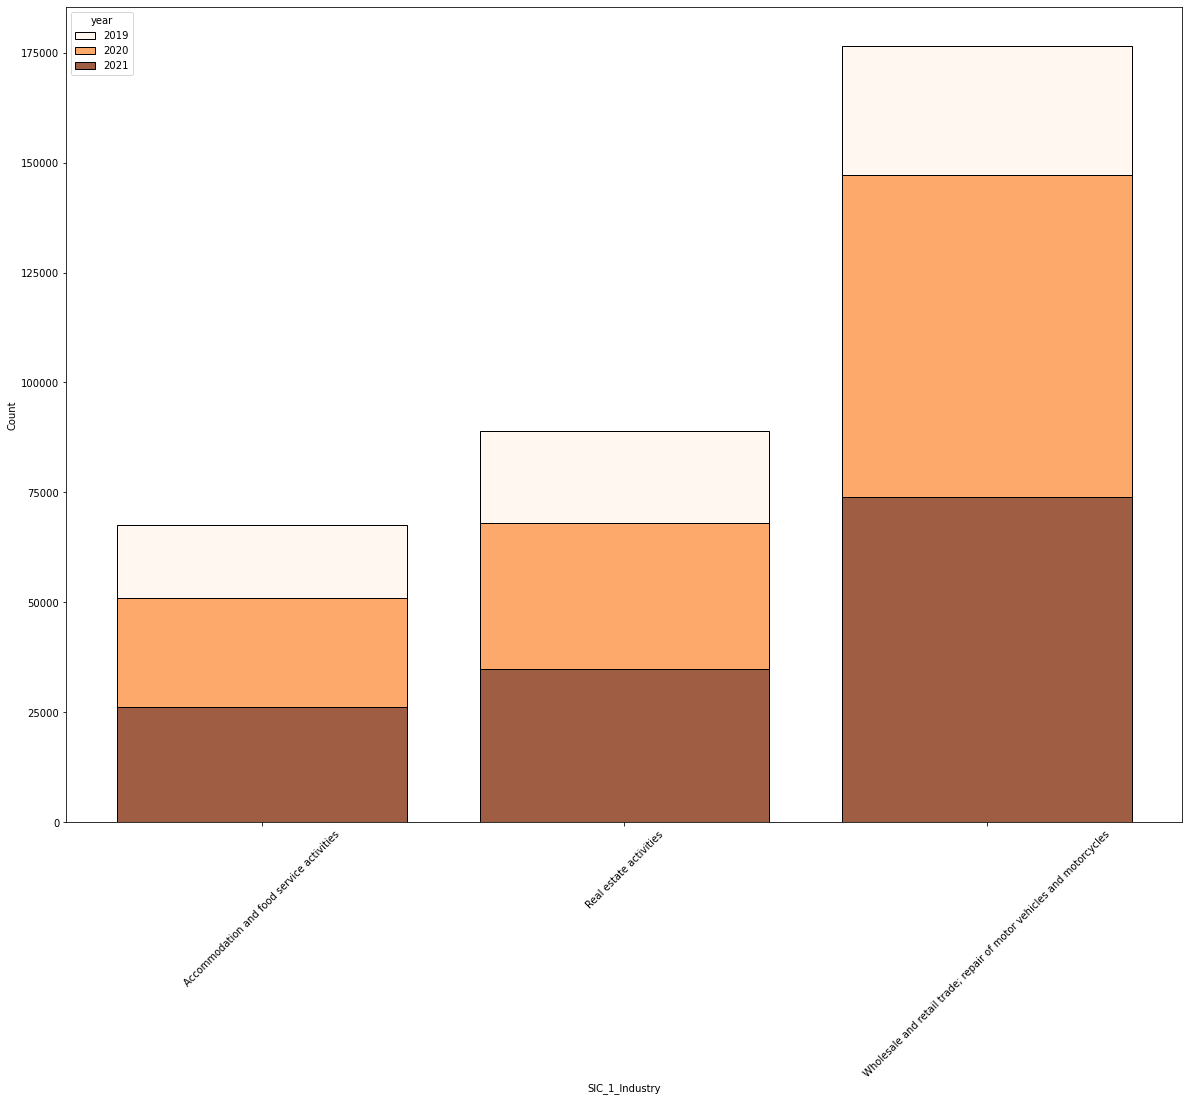

In [37]:
plt.xticks(rotation=45)
ax1 = sns.histplot(df_month_counter2, x='SIC_1_Industry', hue='year', weights='IncorporationDate',
             multiple='stack', palette='Oranges', shrink=0.8)

In [38]:
df_withloc.drop(cols, axis=1, inplace=True)

In [39]:
df_withloc['year'] = pd.DatetimeIndex(df_withloc['IncorporationDate']).year

In [40]:
df_withloc.T

,0,1,2,3,4,5,6,7,8,9,...,980138,980139,980140,980141,980142,980143,980144,980145,980146,980147
IncorporationDate,2021-05-17 00:00:00,2021-12-08 00:00:00,2021-02-23 00:00:00,2021-01-04 00:00:00,2020-04-08 00:00:00,2020-12-02 00:00:00,2019-07-29 00:00:00,2020-12-30 00:00:00,2019-01-10 00:00:00,2020-05-11 00:00:00,...,2020-10-16 00:00:00,2021-05-14 00:00:00,2020-08-31 00:00:00,2020-07-24 00:00:00,2021-10-11 00:00:00,2021-03-29 00:00:00,2019-08-16 00:00:00,2019-12-08 00:00:00,2021-03-22 00:00:00,2020-05-30 00:00:00
SIC_1_Industry,Information and communication,Information and communication,Wholesale and retail trade; repair of motor ve...,Real estate activities,Transportation and storage,Education,Human health and social work activities,"Professional, scientific and technical activities",Manufacturing,Construction,...,Wholesale and retail trade; repair of motor ve...,Wholesale and retail trade; repair of motor ve...,Other service activities,Transportation and storage,Information and communication,Construction,Information and communication,Administrative and support service activities,Accommodation and food service activities,Other service activities
Postcode,CM23 2PJ,WV2 3JH,SW11 2HS,B70 7SP,RM13 8EU,M14 4JF,WV12 4EZ,BS31 2TU,LS25 6BQ,W1B 3HH,...,SW1W 8BJ,SW17 0EZ,EC2A 3AR,W1W 5PF,OX3 8DH,NG32 3QJ,WA1 1RL,CR3 6PQ,CR7 8SE,W8 6BD
County,Hertfordshire,West Midlands,Greater London,West Midlands,Greater London,Greater Manchester,West Midlands,Somerset,North Yorkshire,Greater London,...,Greater London,Greater London,Greater London,Greater London,Oxfordshire,Lincolnshire,Cheshire,Surrey,Greater London,Greater London
Country,England,England,England,England,England,England,England,England,England,England,...,England,England,England,England,England,England,England,England,England,England
Latitude,51.871917,52.571432,51.465268,52.511598,51.517691,53.453463,52.594665,51.40496,53.796692,51.517327,...,51.491622,51.430705,51.526563,51.521673,51.762207,52.983538,53.380833,51.293787,51.39699,51.499423
Longitude,0.147103,-2.129644,-0.175649,-1.997378,0.171971,-2.23837,-2.037537,-2.50916,-1.251169,-0.142383,...,-0.157642,-0.169013,-0.079999,-0.143705,-1.195738,-0.535773,-2.599358,-0.070764,-0.091683,-0.19666
year,2021,2021,2021,2021,2020,2020,2019,2020,2019,2020,...,2020,2021,2020,2020,2021,2021,2019,2019,2021,2020


In [41]:
wholesale_geopan = df_withloc[df_withloc["SIC_1_Industry"]=='Wholesale and retail trade; repair of motor vehicles and motorcycles']
real_estate_geopan = df_withloc[df_withloc["SIC_1_Industry"]=='Real estate activities']
accommodation_geopan = df_withloc[df_withloc["SIC_1_Industry"]=='Accommodation and food service activities']

In [42]:
accommodation_geopan

,IncorporationDate,SIC_1_Industry,Postcode,County,Country,Latitude,Longitude,year
13,2020-04-08,Accommodation and food service activities,NW9 6EB,Greater London,England,51.591690,-0.246858,2020
20,2019-09-27,Accommodation and food service activities,EC2A 3AR,Greater London,England,51.526563,-0.079999,2019
46,2019-11-13,Accommodation and food service activities,EN8 0RY,Hertfordshire,England,51.710193,-0.029764,2019
59,2021-04-05,Accommodation and food service activities,E5 0AR,Greater London,England,51.557104,-0.044107,2021
71,2021-02-19,Accommodation and food service activities,LN1 3EW,Lincolnshire,England,53.238913,-0.539890,2021
...,...,...,...,...,...,...,...,...
980096,2021-10-03,Accommodation and food service activities,HX1 3UA,West Yorkshire,England,53.718901,-1.886768,2021
980097,2021-03-23,Accommodation and food service activities,N2 8EF,Greater London,England,51.594579,-0.171400,2021
980129,2021-06-28,Accommodation and food service activities,RG21 4PT,Hampshire,England,51.265748,-1.071277,2021
980134,2019-11-21,Accommodation and food service activities,RH16 4LL,West Sussex,England,50.997672,-0.103181,2019


In [43]:
gdf_accom = gpd.GeoDataFrame(accommodation_geopan, geometry=gpd.points_from_xy(accommodation_geopan.Longitude, accommodation_geopan.Latitude))


In [44]:
gdf_accom

,IncorporationDate,SIC_1_Industry,Postcode,County,Country,Latitude,Longitude,year,geometry
13,2020-04-08,Accommodation and food service activities,NW9 6EB,Greater London,England,51.591690,-0.246858,2020,POINT (-0.24686 51.59169)
20,2019-09-27,Accommodation and food service activities,EC2A 3AR,Greater London,England,51.526563,-0.079999,2019,POINT (-0.08000 51.52656)
46,2019-11-13,Accommodation and food service activities,EN8 0RY,Hertfordshire,England,51.710193,-0.029764,2019,POINT (-0.02976 51.71019)
59,2021-04-05,Accommodation and food service activities,E5 0AR,Greater London,England,51.557104,-0.044107,2021,POINT (-0.04411 51.55710)
71,2021-02-19,Accommodation and food service activities,LN1 3EW,Lincolnshire,England,53.238913,-0.539890,2021,POINT (-0.53989 53.23891)
...,...,...,...,...,...,...,...,...,...
980096,2021-10-03,Accommodation and food service activities,HX1 3UA,West Yorkshire,England,53.718901,-1.886768,2021,POINT (-1.88677 53.71890)
980097,2021-03-23,Accommodation and food service activities,N2 8EF,Greater London,England,51.594579,-0.171400,2021,POINT (-0.17140 51.59458)
980129,2021-06-28,Accommodation and food service activities,RG21 4PT,Hampshire,England,51.265748,-1.071277,2021,POINT (-1.07128 51.26575)
980134,2019-11-21,Accommodation and food service activities,RH16 4LL,West Sussex,England,50.997672,-0.103181,2019,POINT (-0.10318 50.99767)


In [45]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

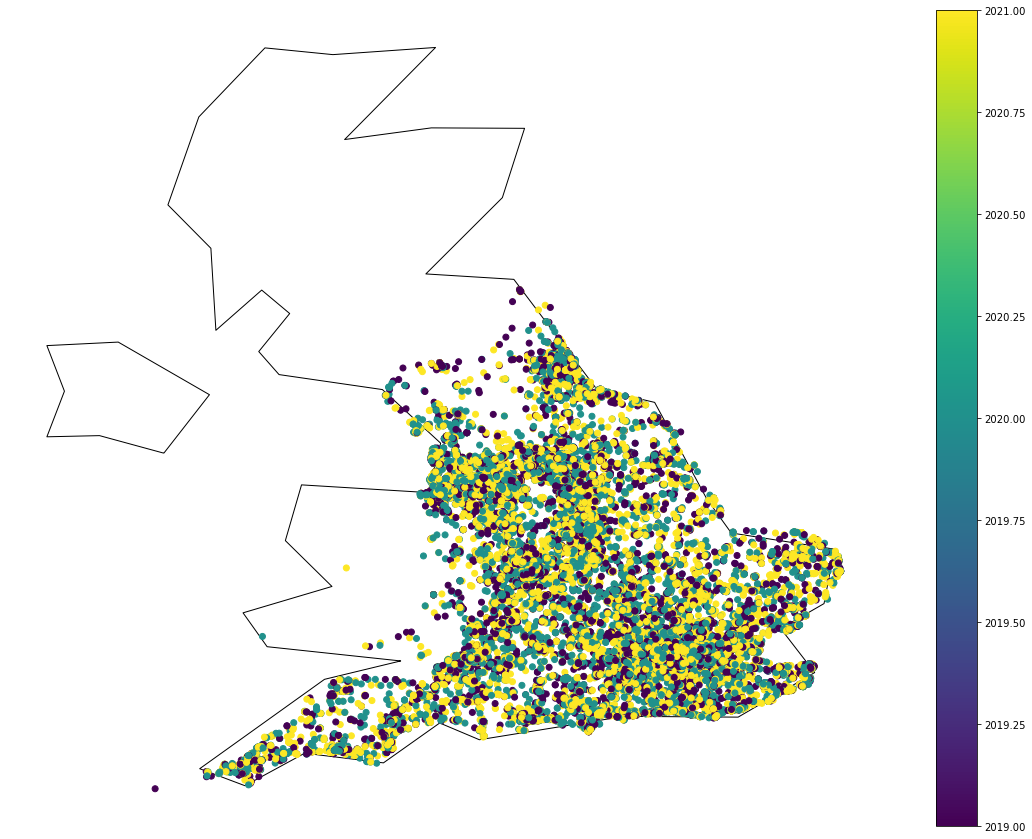

In [46]:
ax3 = world[(world.name == "United Kingdom")].plot(color='white', edgecolor='black')

gdf_accom.plot(ax=ax3, column='year', legend=True)
plt.axis('off')
plt.show()